In [6]:

from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings as wn

from floris.utilities import wrap_360

from flasc.turbine_analysis import northing_offset as nof
from flasc import floris_tools as ftools
from flasc.dataframe_operations import (
    dataframe_manipulations as dfm,
    dataframe_filtering as dff,
)
from flasc.energy_ratio import energy_ratio_wd_bias_estimation as best
from flasc import optimization as flopt
# from flasc import time_operations as fto

from models import load_smarteole_floris

from flasc.energy_ratio import energy_ratio_suite

# Step 0, Load processed data

Load the processed data and inspect

In [3]:
def load_data():
    root_path = Path.cwd()
    f = root_path / "postprocessed" / "df_scada_data_60s_filtered_and_northing_calibrated.ftr"
    df_scada = pd.read_feather(f)

    # # Optionally: downsample to [x] minute averages to speed up things
    # cols_angular = [c for c in df_scada if (("wd_" in c) or ("yaw_" in c))]
    # df_scada = fto.df_downsample(
    #     df_scada,
    #     cols_angular=cols_angular,
    #     window_width=td(seconds=600),
    # )

    return df_scada

df_scada = load_data()

In [5]:
df_scada.head()

,time,pow_000,pow_001,pow_002,pow_003,pow_004,pow_005,pow_006,ws_000,ws_001,...,is_operation_normal_005,is_operation_normal_006,wind_vane_005,target_yaw_offset_005,control_mode,wd_smarteole,ws_smarteole,pow_ref_smarteole,ti,wd
0,2020-02-17 16:30:00,2023.746948,2045.376953,2031.724976,NaN,2028.063965,2032.461060,1983.390991,13.066,12.337,...,True,True,3.299,-0.0,baseline,251.041672,12.582482,2021.060059,0.11,251.377068
1,2020-02-17 16:31:00,1959.036011,2050.572998,2034.890991,NaN,2017.777954,1943.764038,2046.568970,12.091,13.057,...,True,True,1.825,-0.0,baseline,251.282684,12.823891,2022.767212,0.11,251.485048
2,2020-02-17 16:32:00,2053.658936,2032.191040,2011.870972,NaN,NaN,2052.092041,2039.948975,13.381,12.213,...,True,True,8.314,-0.0,baseline,252.874130,12.859400,2034.417480,0.11,253.473037
3,2020-02-17 16:33:00,2044.296997,2060.478027,1995.057983,NaN,NaN,2008.868042,2058.000000,14.345,13.141,...,True,True,2.384,-0.0,baseline,251.341553,13.426766,2039.458252,0.11,251.104001
4,2020-02-17 16:34:00,2058.281006,2042.703003,2031.723999,NaN,NaN,1819.896973,2059.760010,14.338,12.723,...,True,True,17.271,-0.0,baseline,253.343018,13.225105,2048.116943,0.11,255.679234


In [12]:
# Assign wd, ws and pow ref
# Subset dataframe
df_scada = (df_scada
.assign(
    wd = lambda df_: df_['wd_smarteole'],
    ws = lambda df_: df_['ws_smarteole'],
    pow_ref = lambda df_: df_['pow_ref_smarteole']
)
)

In [13]:
# Split df_scada
df_base = df_scada[df_scada.control_mode=='baseline']
df_con = df_scada[df_scada.control_mode=='controlled']

In [14]:
# Compare energy ratios
s = energy_ratio_suite.energy_ratio_suite()
s.add_df(df_base, name="Baseline", color='k')
s.add_df(df_con, name="Controlled", color='r')


Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


array([<Axes: ylabel='Energy ratio (-)'>,
       <Axes: xlabel='Wind direction (deg)', ylabel='Number of data points (-)'>],
      dtype=object)

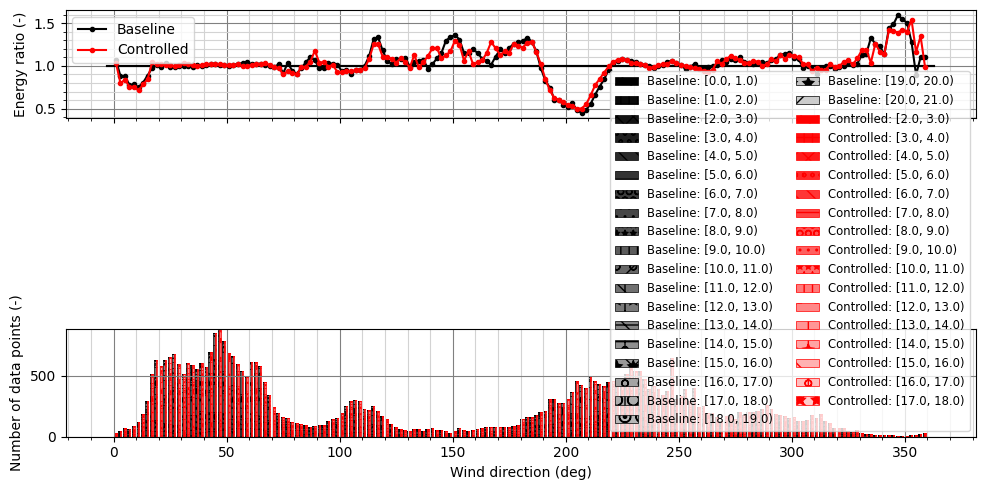

In [15]:
# Check energy ratios on SMV5 (index=4)
s.get_energy_ratios(
            test_turbines=[4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
s.plot_energy_ratios()

Dataframes differ in wd and ws. Rebalancing.
Calculating energy ratios with N = 1.
Calculating energy ratios with N = 1.


array([<Axes: ylabel='Energy ratio (-)'>,
       <Axes: xlabel='Wind direction (deg)', ylabel='Number of data points (-)'>],
      dtype=object)

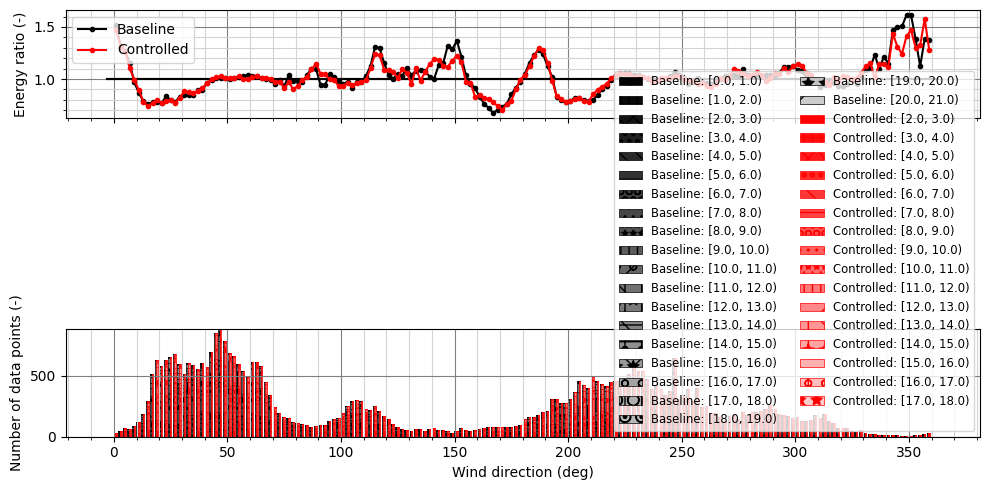

In [16]:
# Check energy ratios on SMV5 (index=4)
s.get_energy_ratios(
            test_turbines=[5,4],
            ws_step=1.0,
            wd_bin_width=2.0,
            wd_step=2.0
        )
s.plot_energy_ratios()